# Titanic | One More Random Forest Solution

The purpose of this work is to get familiar with machine learning basics using the Random Forest algorithm.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import re
import warnings
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

train=pd.read_csv('/kaggle/input/titanic/train.csv')
test=pd.read_csv('/kaggle/input/titanic/test.csv')
# low case letters for column names just for comfortable coding 
train.columns = train.columns.str.lower()
test.columns = test.columns.str.lower()

print ('\033[4m\033[1m' + 'Train table info' + '\033[0m')
display(train.info())
print ('\033[4m\033[1m' + 'Test table info' + '\033[0m')
display(test.info())

Train table info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  891 non-null    int64  
 1   survived     891 non-null    int64  
 2   pclass       891 non-null    int64  
 3   name         891 non-null    object 
 4   sex          891 non-null    object 
 5   age          714 non-null    float64
 6   sibsp        891 non-null    int64  
 7   parch        891 non-null    int64  
 8   ticket       891 non-null    object 
 9   fare         891 non-null    float64
 10  cabin        204 non-null    object 
 11  embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None

Test table info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  418 non-null    int64  
 1   pclass       418 non-null    int64  
 2   name         418 non-null    object 
 3   sex          418 non-null    object 
 4   age          332 non-null    float64
 5   sibsp        418 non-null    int64  
 6   parch        418 non-null    int64  
 7   ticket       418 non-null    object 
 8   fare         417 non-null    float64
 9   cabin        91 non-null     object 
 10  embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None

# 1. Filling NA's
For more accurate filling the missing values, we **combine** the tables. We also create a **'title'** column that contains the honorific from the 'name' column to more accurately fill in the missing age values.

In [2]:
general=pd.concat([train,test], axis=0)

general['fare'] = general.groupby('pclass')['fare'].transform(lambda x: x.fillna(x.median()))
general['embarked'] = general.groupby(['pclass'])['embarked'].transform(lambda x:x.fillna(x.value_counts().idxmax()))
general['title'] = general['name'].apply(lambda x: re.search(' ([A-Za-z]+)\.', x).group(1).lower())
general['age'] = general.groupby(['sex','pclass','title'])['age'].transform(lambda x: x.fillna(x.median()))
general['age'] = general.groupby(['sex','pclass'])['age'].transform(lambda x: x.fillna(x.median())) #Drop 'title' category to fill in the rest of NA's

display(general.head(3))
display(general.info())

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,title
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,mr
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,mrs
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,miss


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 0 to 417
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   passengerid  1309 non-null   int64  
 1   survived     891 non-null    float64
 2   pclass       1309 non-null   int64  
 3   name         1309 non-null   object 
 4   sex          1309 non-null   object 
 5   age          1309 non-null   float64
 6   sibsp        1309 non-null   int64  
 7   parch        1309 non-null   int64  
 8   ticket       1309 non-null   object 
 9   fare         1309 non-null   float64
 10  cabin        295 non-null    object 
 11  embarked     1309 non-null   object 
 12  title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 143.2+ KB


None

In [3]:
display(general['fare'].value_counts().sort_index().head(3))
general.loc[general['fare']==0]
print()
print('Average age of passengers with a free ticket is {:.1f} years.'.format(
    general.loc[general['fare']==0,'age'].mean()))

0.0000    17
3.1708     1
4.0125     1
Name: fare, dtype: int64


Average age of passengers with a free ticket is 35.3 years.


As we can see there are some passengers with free tickets, but they are not children, therefore, we replace the zero values with the average values, depending on the port of embarkation and class.

In [4]:
general['fare'] = general.groupby(['embarked','pclass'])['fare'].transform(lambda x: x.replace(0,x.median()))

# 2. Creating new categories
As we [know](https://www.encyclopedia-titanica.org/deck-plan-key.html), the letter in cabin number means **deck**, so we create a **'deck_id'** column, we extract digits from cabin number as well, and save it as **'cabin_id'**. Odd cabin numbers [means](https://www.encyclopedia-titanica.org/titanic-deckplans/b-deck.html) starboard side (right), and even cabin numbers means port side (left), so let's create **'side_id'** column. Let's extract digits and letters from ticket number as well, and save it as **'ticket_id' and 'ticket_letters**. Also we adding information about total number of **relatives**, **single** vs not single, and split the **'age' and 'fare' into categories**.

In [5]:
decks = {'U': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
general['deck_id'] = general['cabin'].fillna('U').apply(lambda c: decks.get(c[0]))
general['cabin_id'] = general['cabin'].str.extract('(\d+)').astype('float').fillna(0).astype('int')

def even_odd(x):
    if x == 0: return 0
    elif x % 2 == 0: return 2
    else: return 1
general['side_id'] = general['cabin_id'].apply(even_odd)

general['ticket_id'] = general['ticket'].str.extract('(\d+)').astype('float').fillna(0).astype('int')
general[['ticket_letter', 'ticket_number']] = general['ticket'].str.split(' ',n=1, expand=True)
general.loc[general['ticket_number'].isna(), 'ticket_letter'] = 'None'

general['relatives'] = general['parch'] + general['sibsp']
general['is_single'] = general['relatives'].apply(lambda x: 1 if x == 0 else 0)

def age_cat(age):
    if age <= 5:
        return 1
    if age <= 12:
        return 2
    if age <= 15:
        return 3
    if age <= 35:
        return 4
    if age <= 55:
        return 5      
    else:
        return 6
general['age_cat'] = general['age'].apply(age_cat)

general['fare_cat'] = pd.qcut(general['fare'], 8, labels=[1,2,3,4,5,6,7,8]).astype('int')

Let's create columns with **numeric equivalents** of categorical values, such as **'sex_id'**, **'embarked_id'** , **'ticket_letter_id'** and **'title_id'**.

In [6]:
genders = {'male': 1, 'female': 0}
general['sex_id'] = general['sex'].apply(lambda x: genders.get(x))

embarkments = {'S': 1, 'C': 2, 'Q': 3}
general['embarked_id'] = general['embarked'].apply(lambda x: embarkments.get(x))

decks = {'U': 0, 'A': 1, 'B': 2, 'C': 3, 'D': 4, 'E': 5, 'F': 6, 'G': 7, 'T': 8}
general['deck_id'] = general['cabin'].fillna('U').apply(lambda c: decks.get(c[0]))

general['ticket_letter_id'] = LabelEncoder().fit_transform(general['ticket_letter'])

general['title_id'] = LabelEncoder().fit_transform(general['title'])

Converting some of the  categorical variables into **indicator variables**.

In [7]:
sex_dummies = pd.get_dummies(general['sex'], prefix='sex_d', dummy_na=False)
general = pd.concat([general, sex_dummies], axis=1)

embarked_dummies = pd.get_dummies(general['embarked'], prefix='embarked_d', dummy_na=False)
general = pd.concat([general, embarked_dummies], axis=1)

pclass_dummies = pd.get_dummies(general['pclass'], prefix='pclass_d', dummy_na=False)
general = pd.concat([general, pclass_dummies], axis=1)

deck_dummies = pd.get_dummies(general['deck_id'], prefix='deck_d', dummy_na=False)
general = pd.concat([general, deck_dummies], axis=1)

title_dummies = pd.get_dummies(general['title'], prefix='title_d', dummy_na=False)
general = pd.concat([general, title_dummies], axis=1)

# 3. EDA
As we have filled NA's and have crated new categories, we can **split tables back** for analysis.

In [8]:
train_filled = general.head(891)

test_filled = general.tail(418)
test_filled = test_filled.drop('survived', 1)

Let's make **histograms** to estimate the quantitative indicators of the categories. 

In [9]:
categories = ['survived','sex', 'pclass', 'fare', 'embarked', 'age', 'relatives', 'deck_id', 'title']
colors = ['lightgrey','darkkhaki','rosybrown', 'seagreen', 'lightsteelblue', 'goldenrod', 'darkcyan','indianred', 'orange']
c=0
for i in categories:
    fig = px.histogram(train_filled, x=i, color_discrete_sequence=[colors[c]])
    fig.show()
    c+=1

Let's make some **boxplots** as well:

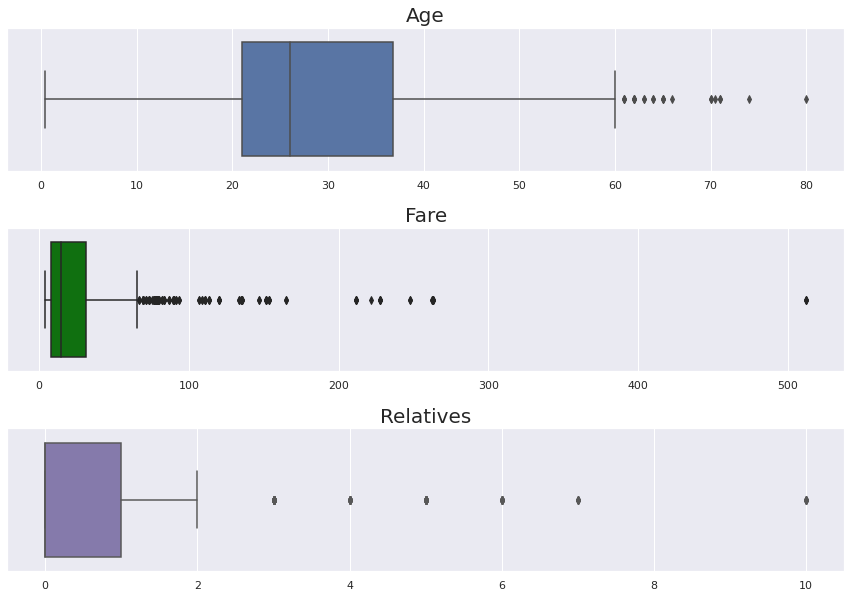

In [10]:
sns.set_theme(style='darkgrid')
fig = plt.figure(figsize=(15,10))
fig.subplots_adjust(hspace=0.4)
ax1 = fig.add_subplot(3,1,1)
ax2 = fig.add_subplot(3,1,2)
ax3 = fig.add_subplot(3,1,3)
sns.boxplot(x='age', data=train_filled, ax=ax1)
sns.boxplot(x='fare', data=train_filled, ax=ax2,color='green')
sns.boxplot(x='relatives', data=train_filled, ax=ax3, color='m')
ax1.set_title('Age', fontsize=20)
ax2.set_title('Fare', fontsize=20)
ax3.set_title('Relatives', fontsize=20)
ax1.set(xlabel=None)
ax2.set(xlabel=None)
ax3.set(xlabel=None)
plt.show()

Let's find out what most affected the **survival rate**.

In [11]:
print ('\033[4m\033[1m' + 'Gender' + '\033[0m')
display(pd.pivot_table(train_filled, index='sex', values='survived').style.background_gradient(cmap='Greens'))
print ('\033[4m\033[1m' + 'Class' + '\033[0m')
display(pd.pivot_table(train_filled, index='pclass', values='survived').style.background_gradient(cmap='Greens'))
print ('\033[4m\033[1m' + 'Fare category' + '\033[0m')
display(pd.pivot_table(train_filled, index='fare_cat', values='survived').style.background_gradient(cmap='Greens'))
print ('\033[4m\033[1m' + 'Embarked' + '\033[0m')
display(pd.pivot_table(train_filled, index='embarked', values='survived').style.background_gradient(cmap='Greens'))
print ('\033[4m\033[1m' + 'Age category' + '\033[0m')
display(pd.pivot_table(train_filled, index='age_cat', values='survived').style.background_gradient(cmap='Greens'))
print ('\033[4m\033[1m' + 'Relatives' + '\033[0m')
display(pd.pivot_table(train_filled, index='relatives', values='survived').style.background_gradient(cmap='Greens'))
print ('\033[4m\033[1m' + 'Deck' + '\033[0m')
display(pd.pivot_table(train_filled, index='deck_id', values='survived').style.background_gradient(cmap='Greens'))
print ('\033[4m\033[1m' + 'Side' + '\033[0m')
display(pd.pivot_table(train_filled, index='side_id', values='survived').style.background_gradient(cmap='Greens'))
print ('\033[4m\033[1m' + 'Title' + '\033[0m')
display(pd.pivot_table(train_filled, index='title', values='survived').style.background_gradient(cmap='Greens'))

Gender


,survived
sex,
female,0.742038
male,0.188908


Class


,survived
pclass,
1,0.629630
2,0.472826
3,0.242363


Fare category


,survived
fare_cat,
1,0.224000
2,0.227723
3,0.198413
4,0.404255
5,0.418182
6,0.470588
7,0.450450
8,0.723810


Embarked


,survived
embarked,
C,0.553571
Q,0.389610
S,0.339009


Age category


,survived
age_cat,
1,0.704545
2,0.379310
3,0.642857
4,0.349462
5,0.407767
6,0.300000


Relatives


,survived
relatives,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


Deck


,survived
deck_id,
0,0.299854
1,0.466667
2,0.744681
3,0.593220
4,0.757576
5,0.750000
6,0.615385
7,0.500000
8,0.000000


Side


,survived
side_id,
0,0.301013
1,0.739130
2,0.611111


Title


,survived
title,
capt,0.000000
col,0.500000
countess,1.000000
don,0.000000
dr,0.428571
jonkheer,0.000000
lady,1.000000
major,0.500000
master,0.575000


As we can see, several categories had the great impact on survival:
   + gender
   + class
   + fare
   + age
   + relatives
   + deck

Let's find out how the categories **correlate** to each other:

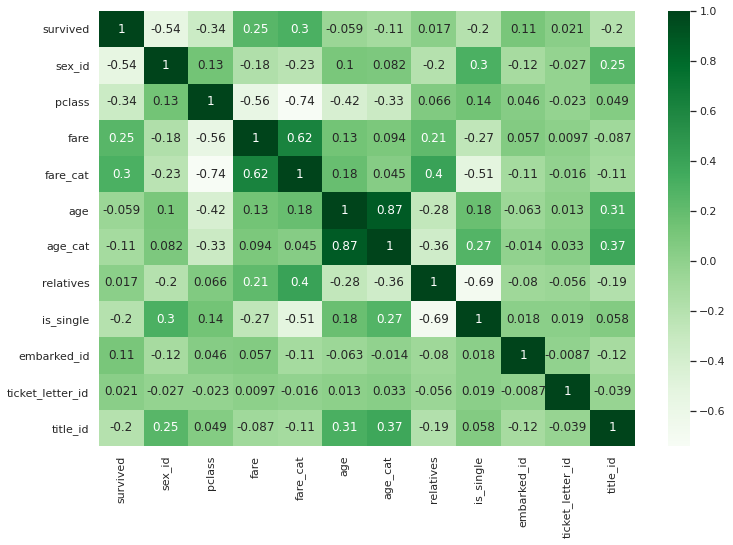

In [12]:
heatmap_data = train_filled[['survived','sex_id','pclass','fare','fare_cat','age', 'age_cat','relatives','is_single','embarked_id', 'ticket_letter_id','title_id']]
fig, ax = plt.subplots(figsize=(12,8))
sns.heatmap(heatmap_data.corr(), annot=True, cmap='Greens')
plt.show()

# 4. Modeling
Let's **select the features**. Let's write each feature from a new line so that it is easy to exclude it using '#':

In [13]:
columns=[
#'passengerid',       
#'survived',          
'pclass',                             
'age', 
'age_cat',
'sibsp',               
'parch',                           
'fare',
'fare_cat',
'sex_id',            
'relatives',           
'embarked_id',        
'is_single',          
'deck_id',           
'cabin_id',
'side_id',
'ticket_id',
#'ticket_letter_id',
'title_id',            
'sex_d_female','sex_d_male',         
'embarked_d_C','embarked_d_Q','embarked_d_S',        
'pclass_d_1','pclass_d_2','pclass_d_3',          
'deck_d_0','deck_d_1','deck_d_2','deck_d_3','deck_d_4','deck_d_5','deck_d_6','deck_d_7','deck_d_8',           
'title_d_capt','title_d_col','title_d_countess','title_d_don','title_d_dona','title_d_dr','title_d_jonkheer',   
'title_d_lady','title_d_major','title_d_master','title_d_miss','title_d_mlle','title_d_mme',       
'title_d_mr','title_d_mrs', 'title_d_ms','title_d_rev','title_d_sir' 
]

test_final = test_filled[columns]
train_final = train_filled[columns]

Let's find out how the **features correlate to 'survived'**:

([Satyabrata Roy](http://www.kaggle.com/satyabrataroy/40-insights-extraction-eda-titanic-dataset), Thank You!)

In [14]:
abs(pd.DataFrame(heatmap_data.corr()['survived'])).sort_values(by='survived', ascending=False).style.background_gradient(cmap='Greens')

,survived
survived,1.000000
sex_id,0.543351
pclass,0.338481
fare_cat,0.304337
fare,0.251381
is_single,0.203367
title_id,0.198170
age_cat,0.109968
embarked_id,0.106811
age,0.059304


Let's evaluate the **importance of features** using the **RandomForestClassifier** algorithm:

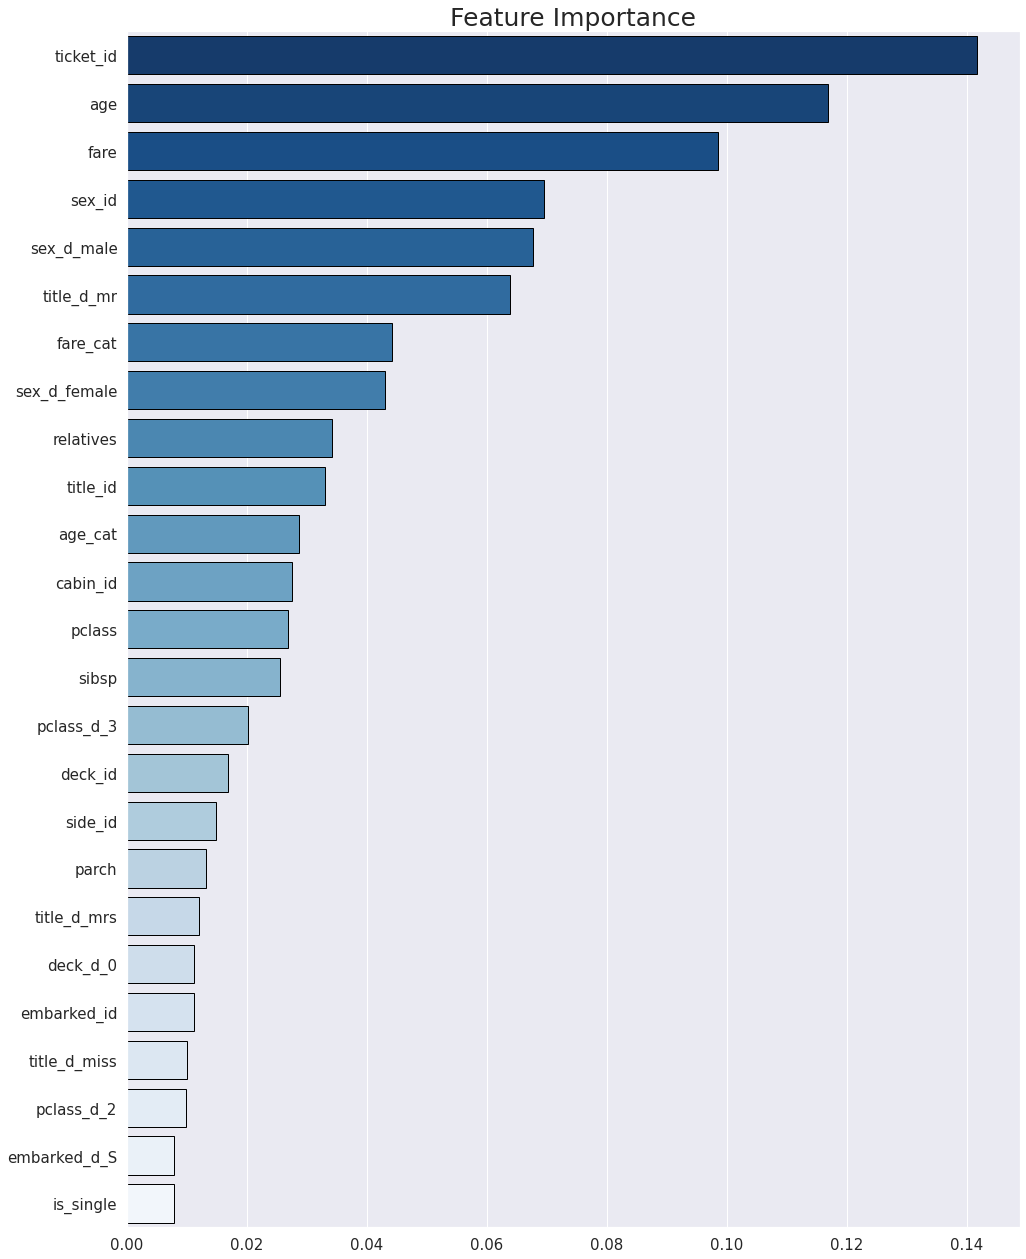

In [15]:
model = RandomForestClassifier()
model.fit(train_final, train_filled['survived'])
feature_imp = pd.Series(model.feature_importances_, index=train_final.columns).sort_values(ascending=False).nlargest(25)
plt.figure(figsize=[16,22])
ax=sns.barplot(y=feature_imp.index, x=feature_imp, palette='Blues_r', edgecolor='black')
ax.axes.set_title('Feature Importance',fontsize=25)
ax.tick_params(labelsize=15)
plt.show()   

Using **Cross-validation**:

In [16]:
cv = StratifiedKFold(n_splits=3, random_state=None, shuffle=False)
model = RandomForestClassifier(random_state=1, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
scores = cross_val_score(model, train_final, train_filled['survived'], cv=cv, n_jobs=-1)
print("Accuracy/standard deviation: {}/{}".format(scores.mean(), scores.std()))

Accuracy/standard deviation: 0.8428731762065095/0.02063386791341216


To achieve the best result, we can **exclude features** from the list above.

Determining the **best parameters**:

In [17]:
model = RandomForestClassifier(random_state=1)
params = [{
    'n_estimators': [100, 350, 500],
    'min_samples_split': [6, 8, 10],
    'min_samples_leaf': [2, 4, 6]
}]
grid = GridSearchCV(model, params, cv=cv, refit=True, verbose=1, n_jobs=-1)
grid.fit(train_final, train_filled['survived'])
best = grid.best_estimator_
print('Accuracy (random forest auto): {} with params {}'
      .format(grid.best_score_, grid.best_params_))

Fitting 3 folds for each of 27 candidates, totalling 81 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done  81 out of  81 | elapsed:   23.5s finished


Accuracy (random forest auto): 0.8428731762065095 with params {'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 500}


Generating an **output file** using best parameters:

In [18]:
model = RandomForestClassifier(random_state=1, n_estimators=500, min_samples_split=8, min_samples_leaf=2)
model.fit(train_final, train_filled['survived'])
predictions = model.predict(test_final)
submission = pd.DataFrame({
    'PassengerId': test_filled['passengerid'],
    'Survived': predictions
})

submission['Survived'] = submission['Survived'].astype(int)

In [19]:
submission.to_csv('titanic_submission_ver8.csv', index=False)

## Thank's for reading)